In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Loading Dataset
dataset=pd.read_csv('/housing.csv')

#Removing Missing values
dataset=dataset.dropna()

#Printing first 10 Data-set
print('here are 10 dataset')
dataset.head(10)







here are 10 dataset


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
#getting x and y co-ordinate
Y=dataset['median_house_value']
X=dataset.loc[:,'longitude':'median_income']

#Splitting dataset into 70:30. 70% is for training is for training and 30% dataset is for testing
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)


#Converting dataset to arrays
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()


x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

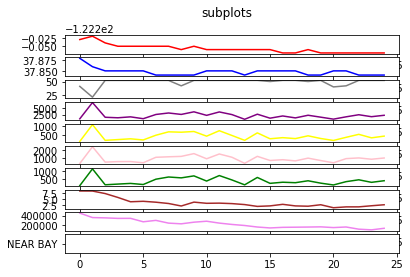

In [4]:
#plotting first 25 dataset (Coloums) of each dataset on graph
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10)
fig.suptitle('subplots')
lst = [i for i in range(25)]

ax1.plot(lst, dataset['longitude'][0:25],color='red',label='longitude')
ax2.plot(lst, dataset['latitude'][0:25],color='blue')
ax3.plot(lst, dataset['housing_median_age'][0:25],color='grey')
ax4.plot(lst, dataset['total_rooms'][0:25],color='purple')
ax5.plot(lst, dataset['total_bedrooms'][0:25], color='yellow')
ax6.plot(lst,dataset['population'][0:25],color = 'pink')
ax7.plot(lst, dataset['households'][0:25],color='green')
ax8.plot(lst, dataset['median_income'][0:25],color='brown')
ax9.plot(lst, dataset['median_house_value'][0:25],color='violet')
ax10.plot(lst, dataset['ocean_proximity'][0:25],color='white')

In [0]:
# Initializing a network

import torch
import torch.optim
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Linear
from torch.nn import Flatten
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

class CnnRegressor(torch.nn.Module):
  def __init__(self,btach_size,inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, batch_size, 1)

    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size, 128, 1)
    
    self.max_pooling_layer_1 = MaxPool1d(1)
    self.conv_layer_1 = Conv1d(128, 128, 1)
    
    
    
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(128, 64)
    self.output_layer = Linear(64, outputs)
  
  def feed(self,input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output= relu(self.conv_layer(output))

    output = self.max_pooling_layer_1(output)
    output= relu(self.conv_layer_1(output))

  

    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output)
    return output

In [6]:
#Training model

from torch.optim import Adam
from torch.nn import CTCLoss
from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

#define Model

batch_size=64 #dont go high error would be insane

model=CnnRegressor(batch_size,X.shape[1],1)
model.cuda()

def model_loss(model, dataset, train=False, optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()

  avg_loss=0
  avg_score=0
  count=0

  for input, output in iter(dataset):
    prediction=model.feed(input)
    loss=performance(prediction,output)
    score_metric.update([prediction,output])
    score=score_metric.compute()
    

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss+=loss.item()
    avg_score+=score
    count+=1

  return avg_loss / count, avg_score / count 

     |████████████████████████████████| 122kB 44.4MB/s 


In [0]:
import time




epochs=637
#optimizer=ASGD(model.parameters(),lr=0.000001,lambd=0.0001, alpha=0.50)
#optimizer=Rprop(model.parameters(), lr=0.0000009, etas=(0.2, 1.2), step_sizes=(1e-05, 50))
optimizer=Adam(model.parameters())
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
begin=time.time()
for epoch in range(epochs):
  avg_loss, avg_r2_score= model_loss(model,loader,train=True,optimizer=optimizer)

  print("epoch" + str(epoch+1)+":\ntloss = "+ str(avg_loss)+"\n\tR^2 Score= "+ str(avg_r2_score))






# New Section

In [8]:
inputs=torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score=model_loss(model,loader)
end=time.time()
print("the model's L1 loss is:" + str(avg_loss) )
print("the model's R^2 score is: "+ str(avg_r2_score))
print("Overall Time : " + str(end-begin))

the model's L1 loss is:45278.60828536184
the model's R^2 score is: 0.696324726943237
Overall Time : 474.5450975894928


In [0]:
model_save_name = '1105610_1dconv_reg.pt'
path = "/content/drive/My Drive/1105610_1dconv_reg.pt" 
torch.save(model.state_dict(), path)
